DATA INGESTION

Client and Session Connection 

In [51]:
import sagemaker
import boto3

sm_boto3 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = 'crasagemakerbucket'

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\naman\AppData\Local\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\naman\AppData\Local\sagemaker\sagemaker\config.yaml


Model

In [52]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# liberary loading
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from scipy import stats
import warnings
warnings.simplefilter('ignore', category=UserWarning)  # suppresses warning message from Seaborn

# command below ensures matplotlib output can be included in Notebook
custom_palette = ["#0571b0", "#f7a440"]  

# Set this custom palette 
sns.set_palette(custom_palette)

%matplotlib inline

In [53]:
#Read CSV file and create pandas dataframe
df = pd.read_csv("German Credit Risk Data.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df_copy = df

In [54]:
df.head(10)

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Risk
0,less than 0 DM,6,critical account/other credits existing (not a...,radio/television,1169,unknown/ no savings account,more than 7 years,4,male : single,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,Good
1,between 0 to 200 DM,48,existing credits paid back duly till now,radio/television,5951,less than 100 DM,between 1 to 4 years,2,female : divorced/separated/married,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,Bad
2,no checking account,12,critical account/other credits existing (not a...,education,2096,less than 100 DM,between 4 to 7 years,2,male : single,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,Good
3,less than 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,less than 100 DM,between 4 to 7 years,2,male : single,gaurantor,...,building society savings agreement/life insurance,45,none,for free,1,skilled employee / official,2,none,yes,Good
4,less than 0 DM,24,delay in paying off in the past,car (new),4870,less than 100 DM,between 1 to 4 years,3,male : single,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,Bad
5,no checking account,36,existing credits paid back duly till now,education,9055,unknown/ no savings account,between 1 to 4 years,2,male : single,none,...,unknown / no property,35,none,for free,1,unskilled - resident,2,"yes, registered under the customers name",yes,Good
6,no checking account,24,existing credits paid back duly till now,furniture/equipment,2835,between 500 to 1000 DM,more than 7 years,3,male : single,none,...,building society savings agreement/life insurance,53,none,own,1,skilled employee / official,1,none,yes,Good
7,between 0 to 200 DM,36,existing credits paid back duly till now,car (used),6948,less than 100 DM,between 1 to 4 years,2,male : single,none,...,"car or other, not in attribute 6",35,none,rent,1,management/self-employed/highly qualified empl...,1,"yes, registered under the customers name",yes,Good
8,no checking account,12,existing credits paid back duly till now,radio/television,3059,more than 1000 DM,between 4 to 7 years,2,male : divorced/separated,none,...,real estate,61,none,own,1,unskilled - resident,1,none,yes,Good
9,between 0 to 200 DM,30,critical account/other credits existing (not a...,car (new),5234,less than 100 DM,unemployed,4,male : married/widowed,none,...,"car or other, not in attribute 6",28,none,own,2,management/self-employed/highly qualified empl...,1,none,yes,Bad


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       1000 non-null   object
 1   Duration in month                                         1000 non-null   int64 
 2   Credit history                                            1000 non-null   object
 3   Purpose                                                   1000 non-null   object
 4   Credit amount                                             1000 non-null   int64 
 5   Savings account/bonds                                     1000 non-null   object
 6   Present employment since                                  1000 non-null   object
 7   Installment rate in percentage of disposable income       1000 non-null   int64 
 8   Personal status and sex      

In [56]:
df.nunique()

Status of existing checking account                           4
Duration in month                                            33
Credit history                                                5
Purpose                                                       9
Credit amount                                               921
Savings account/bonds                                         5
Present employment since                                      5
Installment rate in percentage of disposable income           4
Personal status and sex                                       4
Other debtors / guarantors                                    3
Present residence since                                       4
Property                                                      4
Age in years                                                 53
Other installment plans                                       3
Housing                                                       3
Number of existing credits at this bank 

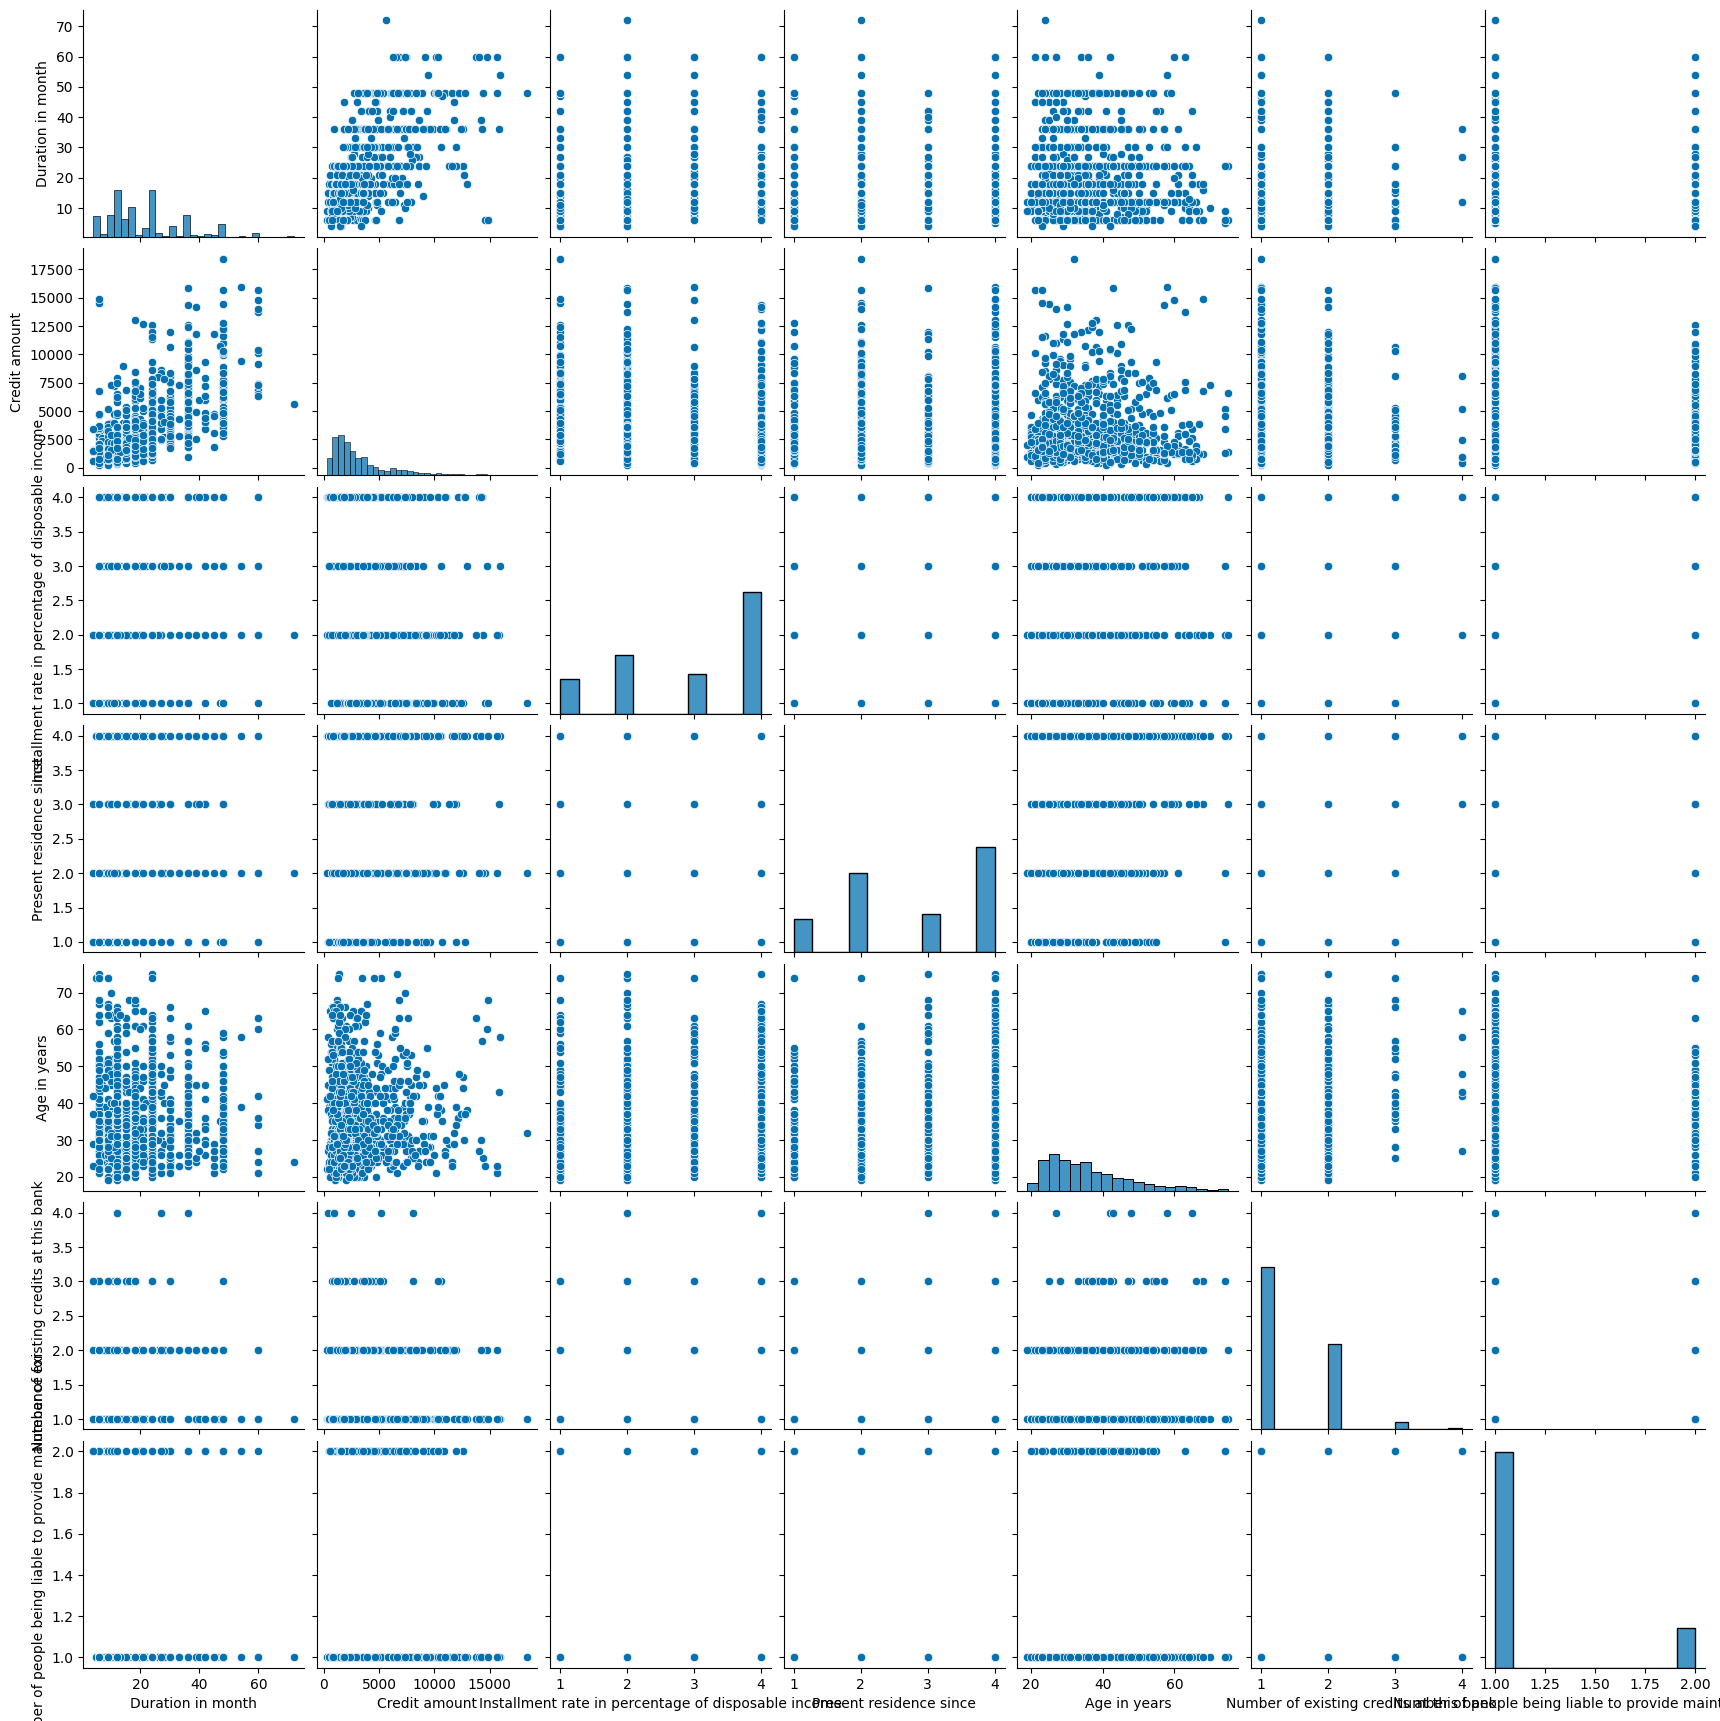

In [57]:
sns.pairplot(df)

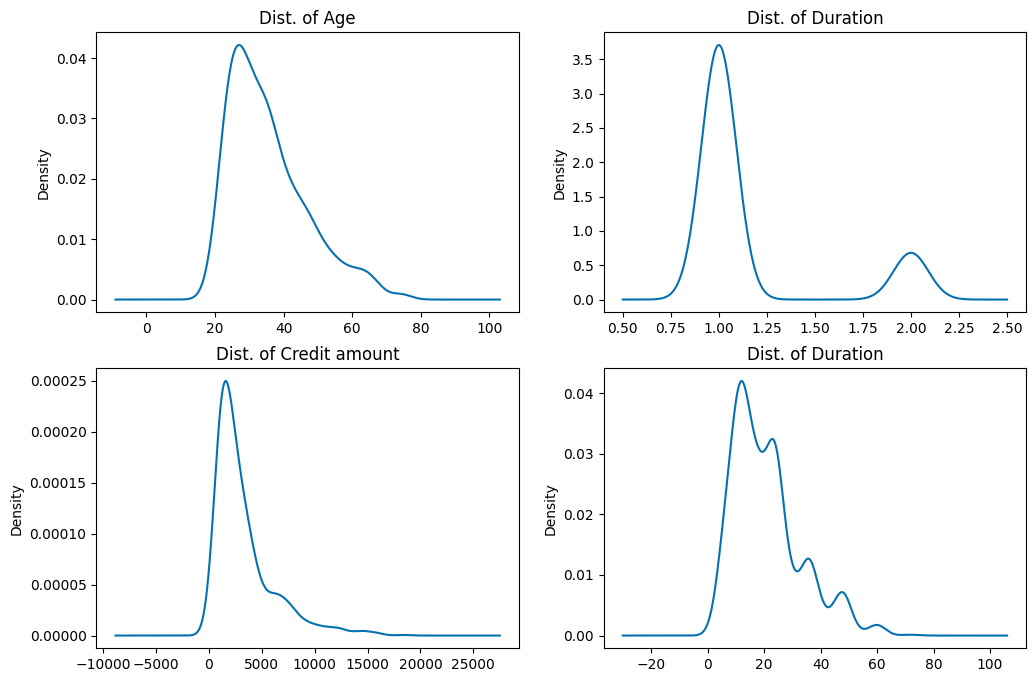

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
df['Age in years'].plot(kind="density",ax=axes[0,0],title="Dist. of Age")
df['Credit amount'].plot(kind="density",ax=axes[1,0],title="Dist. of Credit amount")
df['Duration in month'].plot(kind="density",ax=axes[1,1],title="Dist. of Duration")
df['Number of people being liable to provide maintenance for'].plot(kind="density",ax=axes[0,1],title="Dist. of Duration")
plt.show()

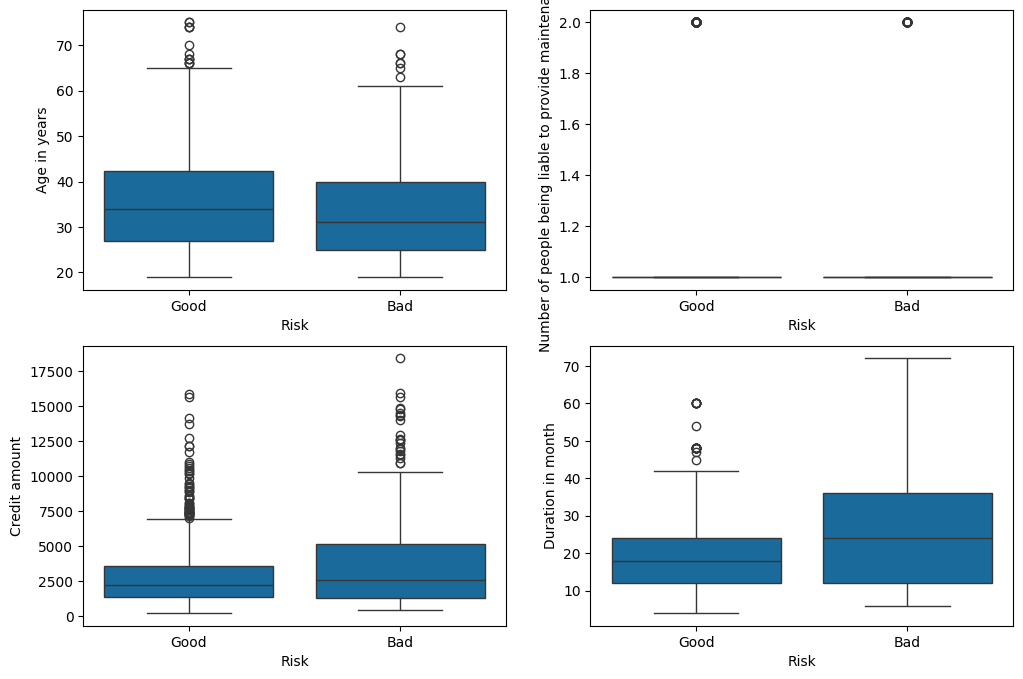

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
sns.boxplot(x="Risk",y="Age in years",data=df,ax=axes[0,0])
sns.boxplot(x="Risk",y="Credit amount",data=df,ax=axes[1,0])
sns.boxplot(x="Risk",y="Duration in month",data=df,ax=axes[1,1])
sns.boxplot(x="Risk",y="Number of people being liable to provide maintenance for",data=df_copy,ax=axes[0,1])
plt.show()

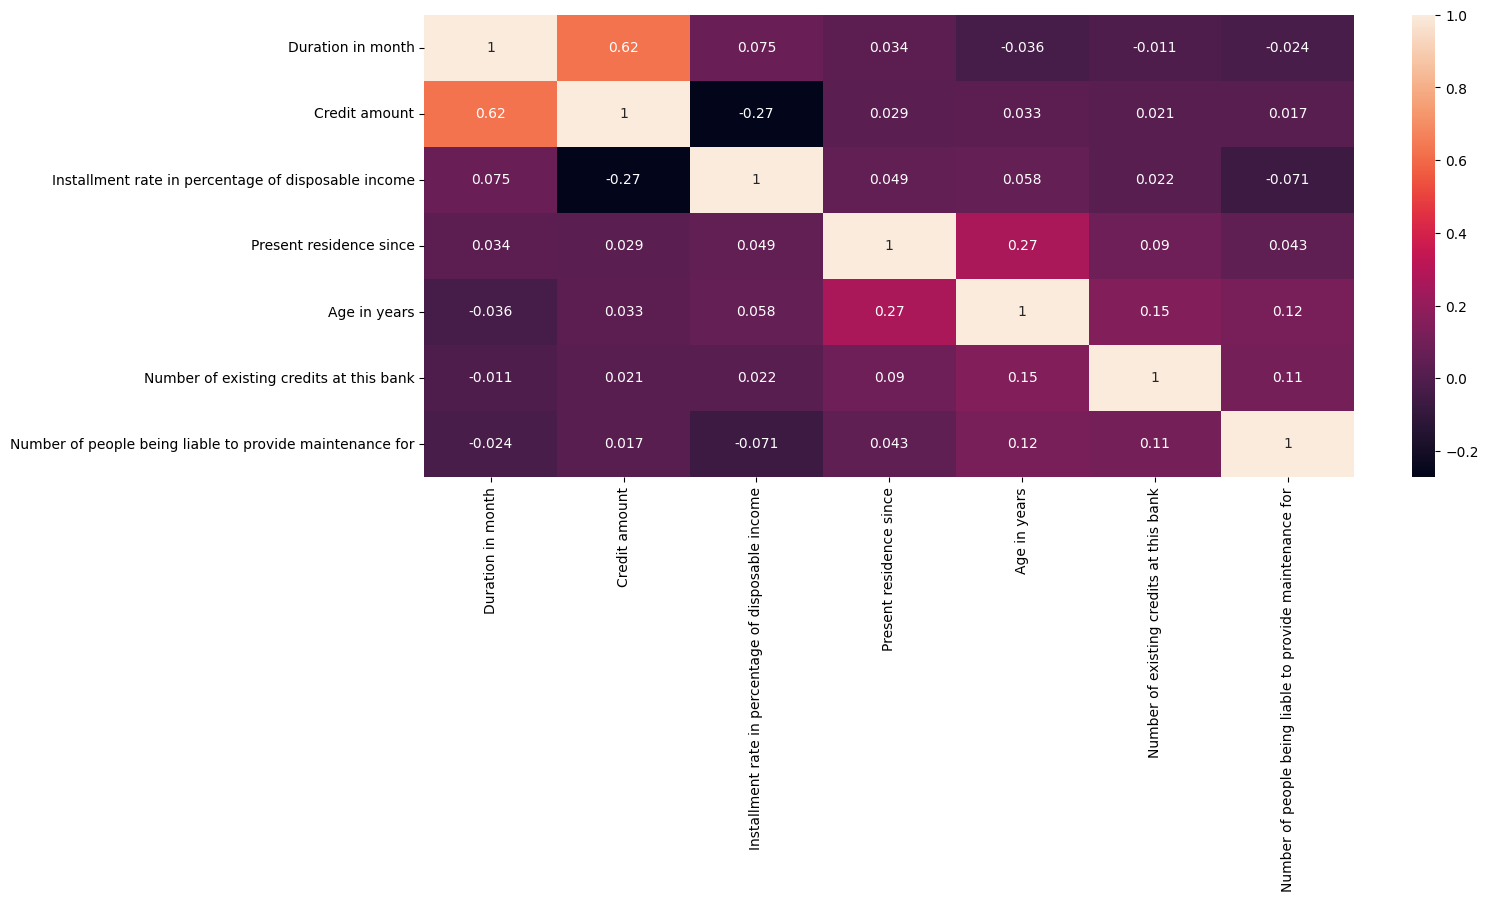

In [60]:
corr=df.select_dtypes(include=['integer']).corr() # gives us the correlation values
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True)  # let's visualise the correlation matrix
plt.show()

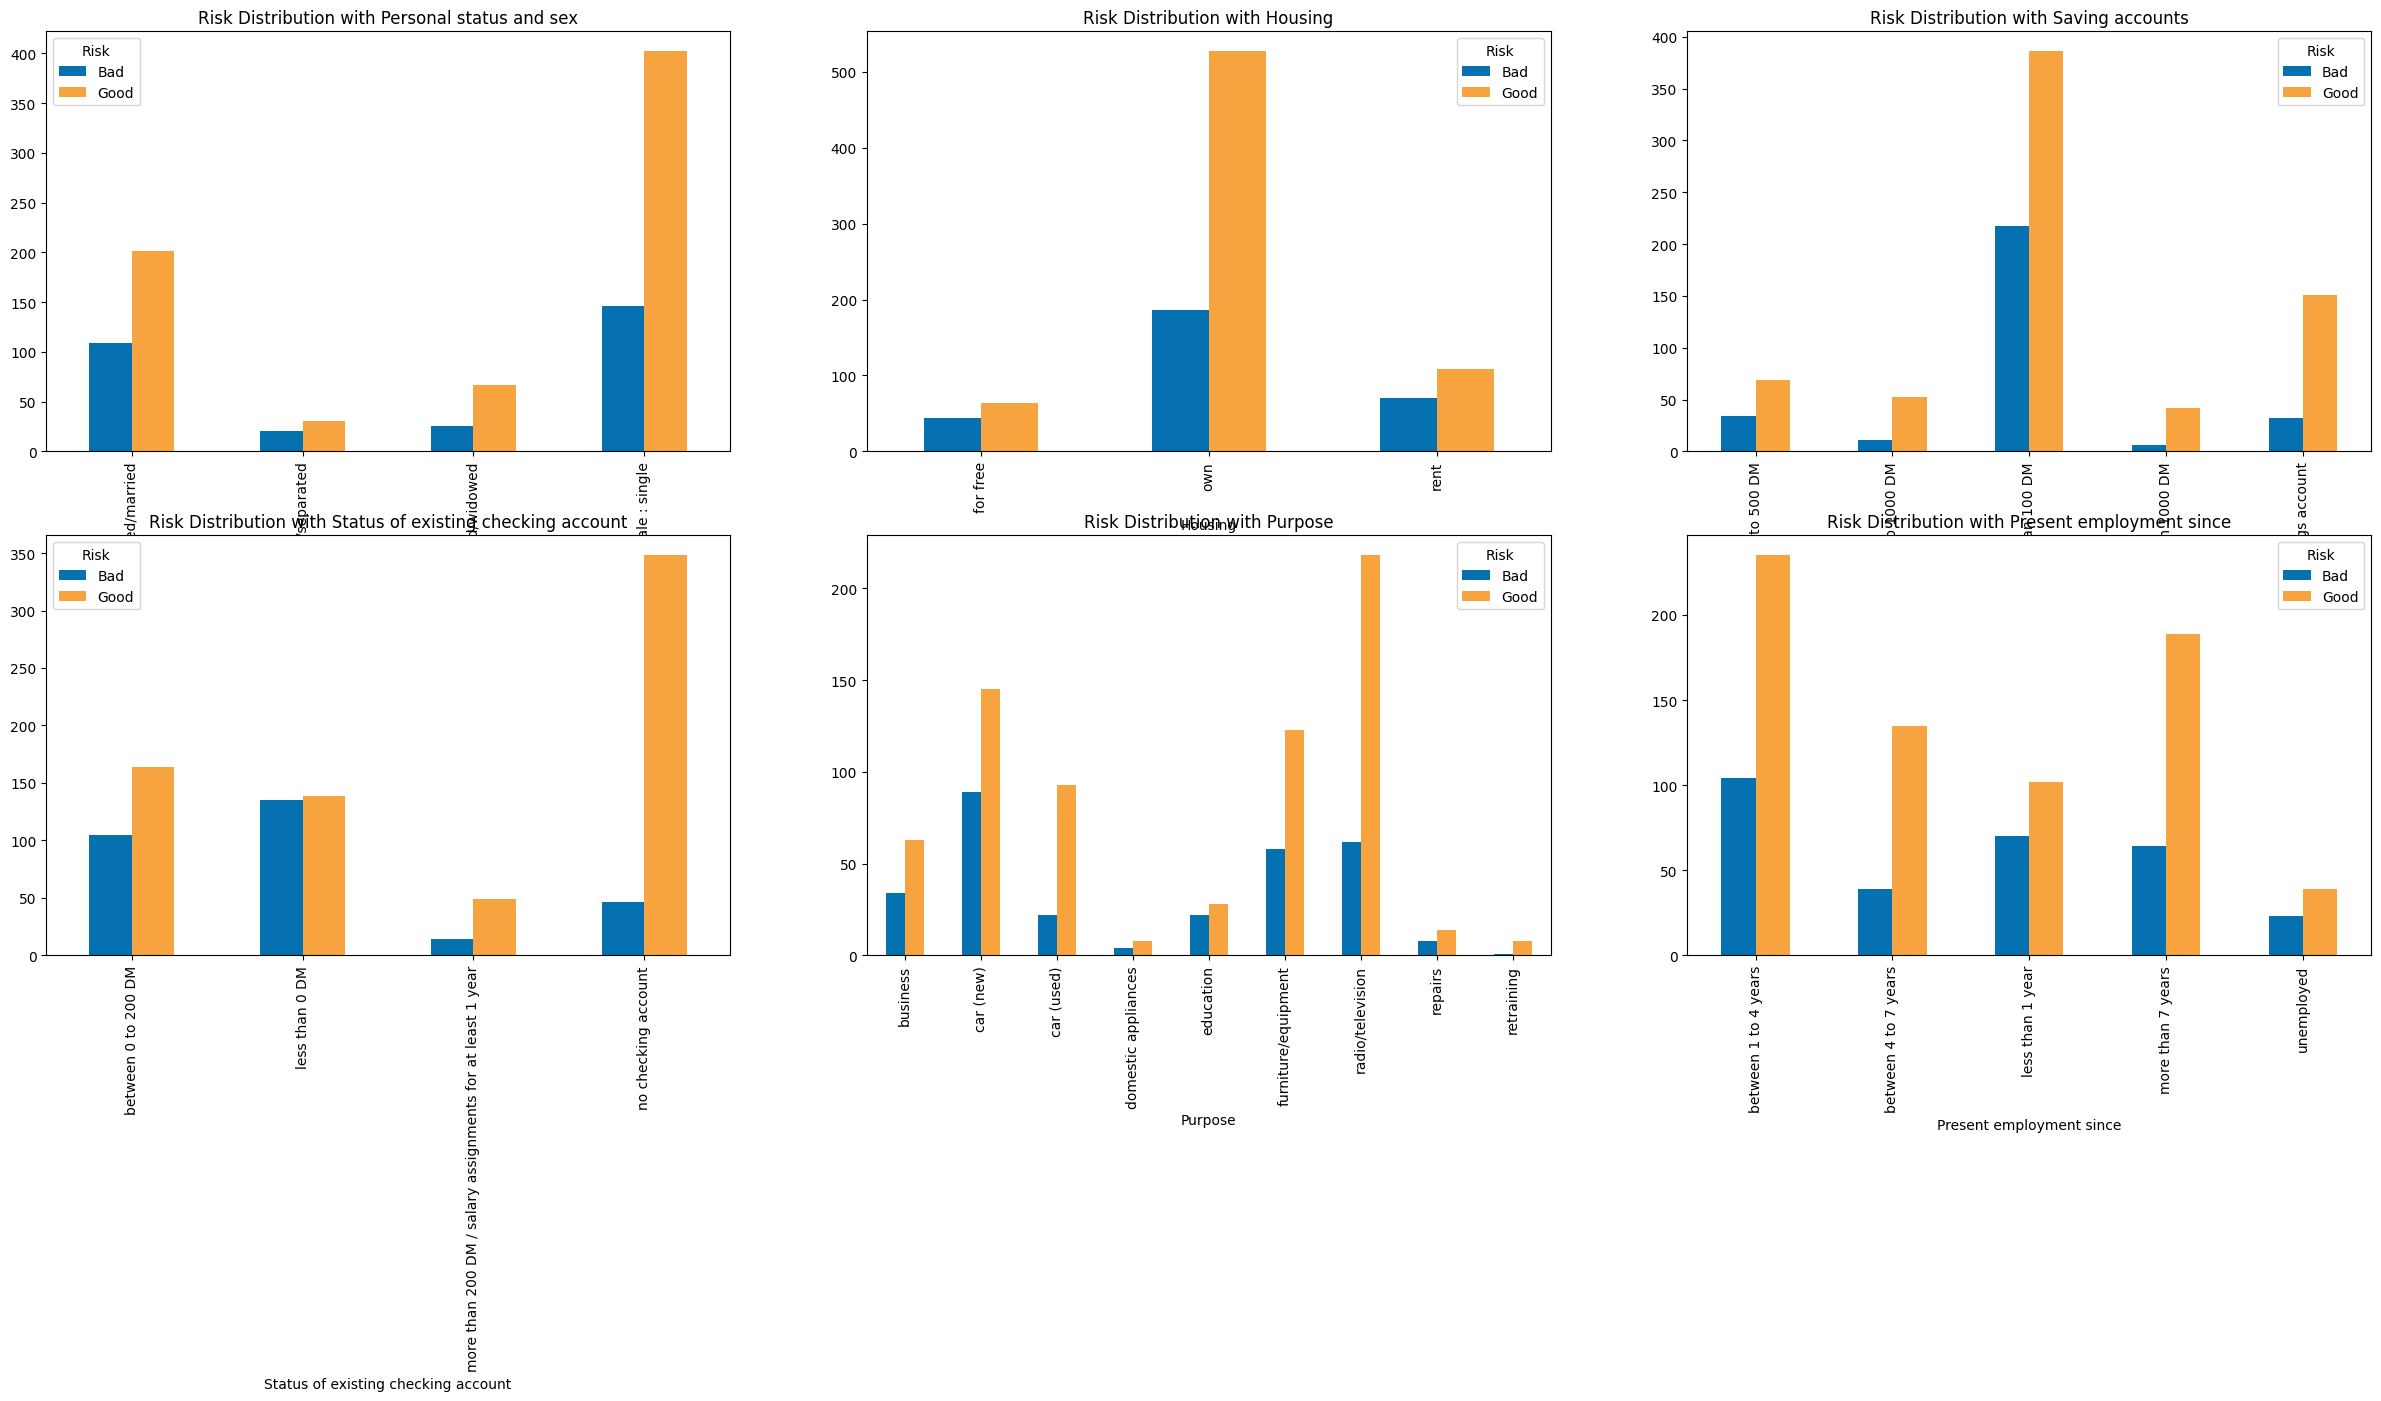

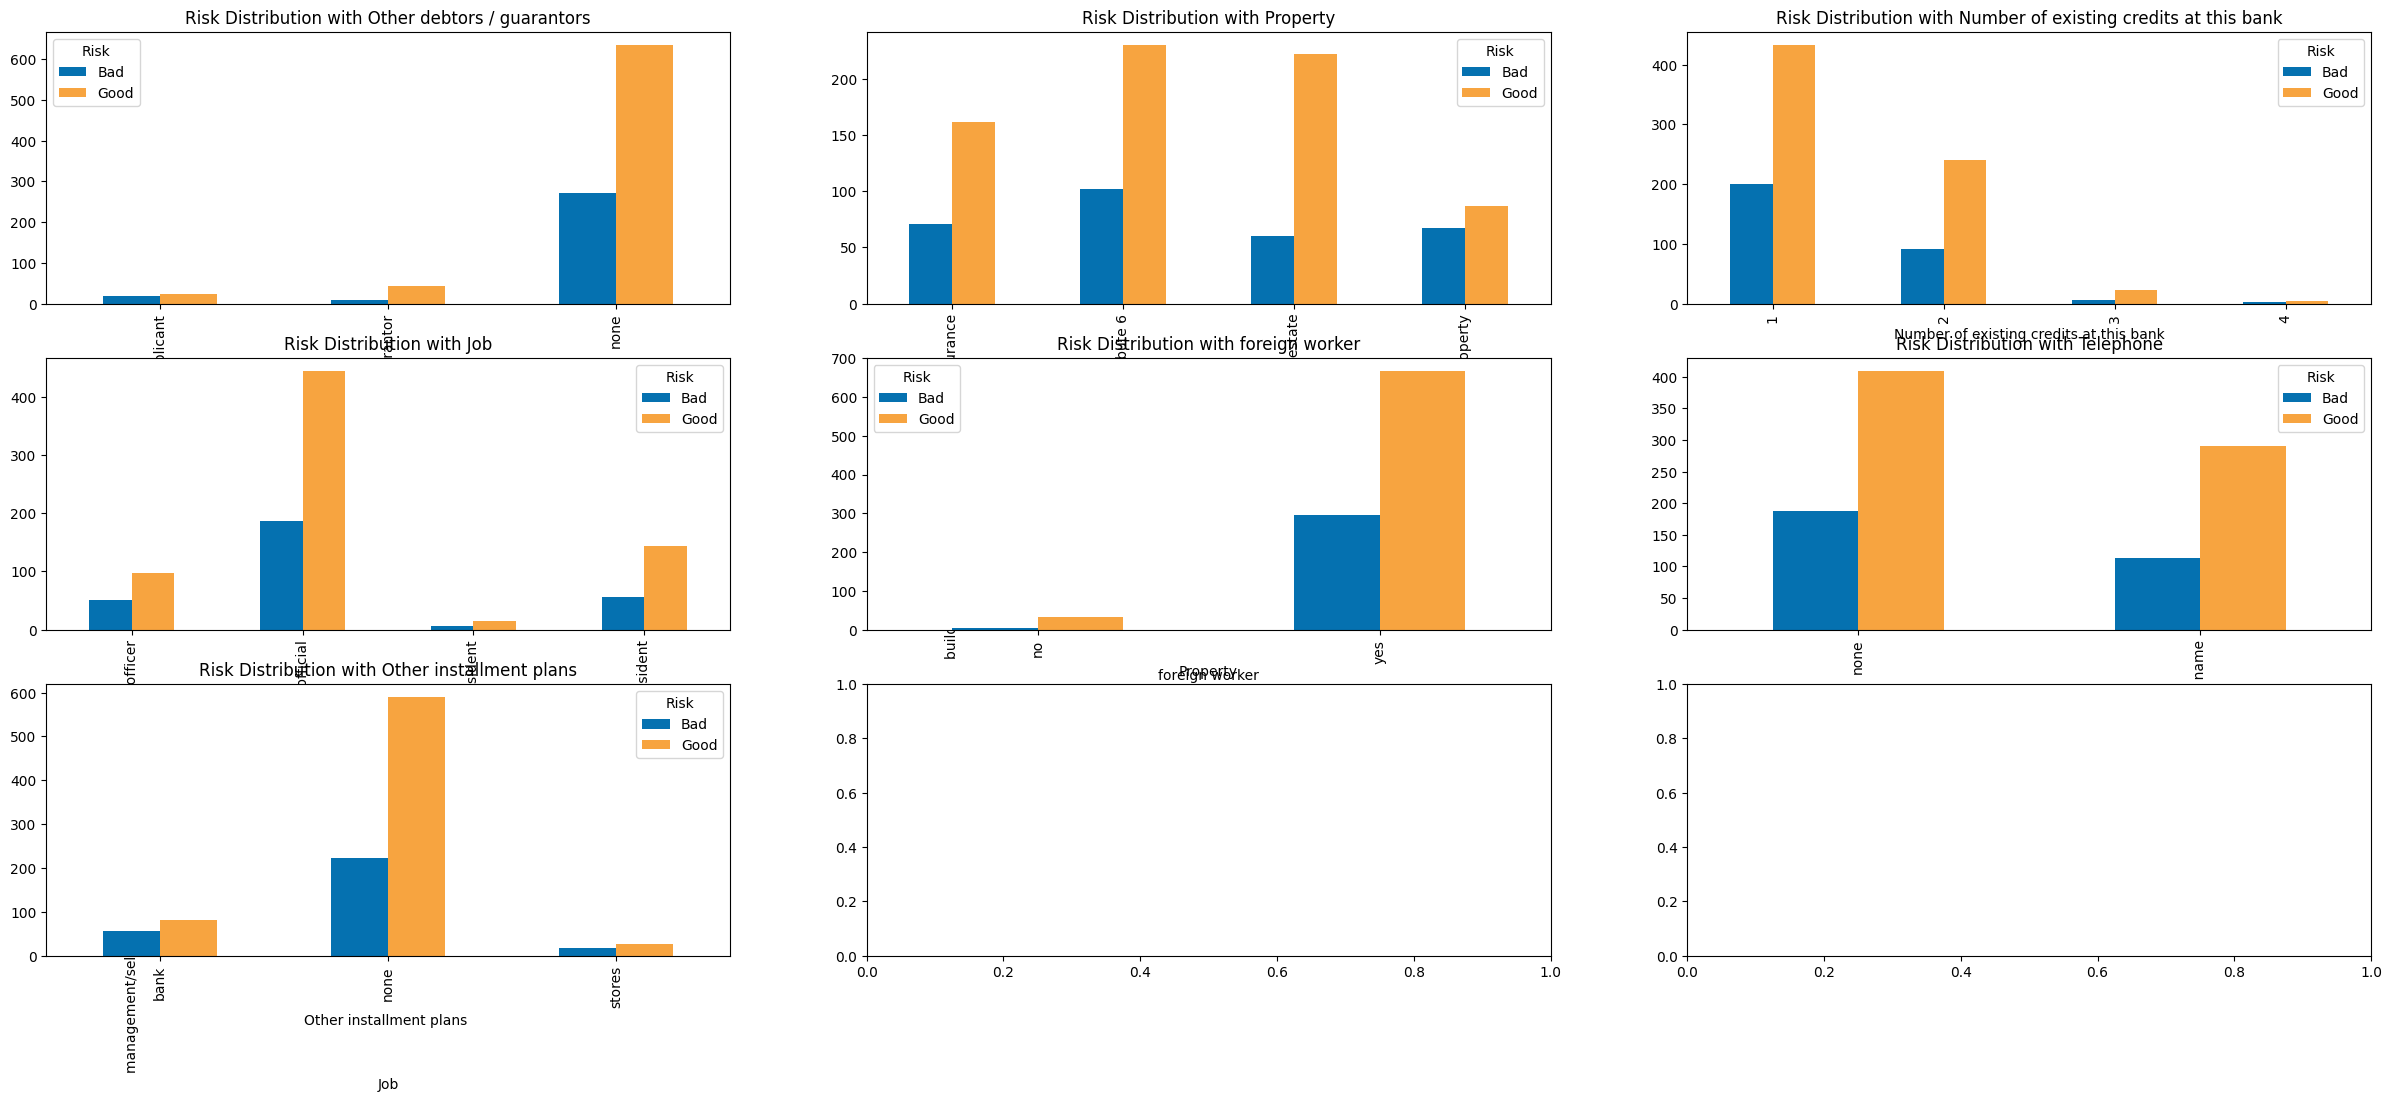

In [61]:
#Plot cross tabulation of features with Risk
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 12))
sex = pd.crosstab(df['Personal status and sex'],df['Risk'])
sex.plot(kind='bar',title="Risk Distribution with Personal status and sex",ax=axes[0,0])
housing = pd.crosstab(df['Housing'],df['Risk'])
housing.plot(kind='bar',title="Risk Distribution with Housing",ax=axes[0,1])
saving_acc = pd.crosstab(df['Savings account/bonds'],df['Risk'])
saving_acc.plot(kind='bar',title="Risk Distribution with Saving accounts",ax=axes[0,2])
checking_acc = pd.crosstab(df['Status of existing checking account'],df['Risk'])
checking_acc.plot(kind='bar',title="Risk Distribution with Status of existing checking account",ax=axes[1,0])
purpose = pd.crosstab(df['Purpose'],df['Risk'])
purpose.plot(kind='bar',title="Risk Distribution with Purpose",ax=axes[1,1])
pes = pd.crosstab(df['Present employment since'],df['Risk'])
pes.plot(kind='bar',title="Risk Distribution with Present employment since",ax=axes[1,2])
plt.show()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 12))
odg = pd.crosstab(df['Other debtors / guarantors'],df['Risk'])
odg.plot(kind='bar',title="Risk Distribution with Other debtors / guarantors",ax=axes[0,0])
prop = pd.crosstab(df['Property'],df['Risk'])
prop.plot(kind='bar',title="Risk Distribution with Property",ax=axes[0,1])
existing_crd = pd.crosstab(df['Number of existing credits at this bank'],df['Risk'])
existing_crd.plot(kind='bar',title="Risk Distribution with Number of existing credits at this bank",ax=axes[0,2])
job = pd.crosstab(df['Job'],df['Risk'])
job.plot(kind='bar',title="Risk Distribution with Job",ax=axes[1,0])
foreign_worker = pd.crosstab(df['foreign worker'],df['Risk'])
foreign_worker.plot(kind='bar',title="Risk Distribution with foreign worker",ax=axes[1,1])
tel = pd.crosstab(df['Telephone'],df['Risk'])
tel.plot(kind='bar',title="Risk Distribution with Telephone",ax=axes[1,2])
oip = pd.crosstab(df['Other installment plans '],df['Risk'])
oip.plot(kind='bar',title="Risk Distribution with Other installment plans",ax=axes[2,0])
plt.show()


In [62]:
Q1=df_copy['Age in years'].quantile(0.25)
Q3=df_copy['Age in years'].quantile(0.75)
IQR=Q3-Q1
Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
df_copy = df_copy[df_copy['Age in years']< Upper_Whisker]
df_copy = df_copy[df_copy['Age in years']> Lower_Whisker]

threshold = 4
for i in range(threshold):
    Q1=df_copy['Credit amount'].quantile(0.25)
    Q3=df_copy['Credit amount'].quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1-1.5*IQR
    Upper_Whisker = Q3+1.5*IQR
    df_copy = df_copy[df_copy['Credit amount']< Upper_Whisker]
    df_copy = df_copy[df_copy['Credit amount']> Lower_Whisker]

Q1=df_copy['Duration in month'].quantile(0.25)
Q3=df_copy['Duration in month'].quantile(0.75)
IQR=Q3-Q1
Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
df_copy = df_copy[df_copy['Duration in month']< Upper_Whisker]
df_copy = df_copy[df_copy['Duration in month']> Lower_Whisker]

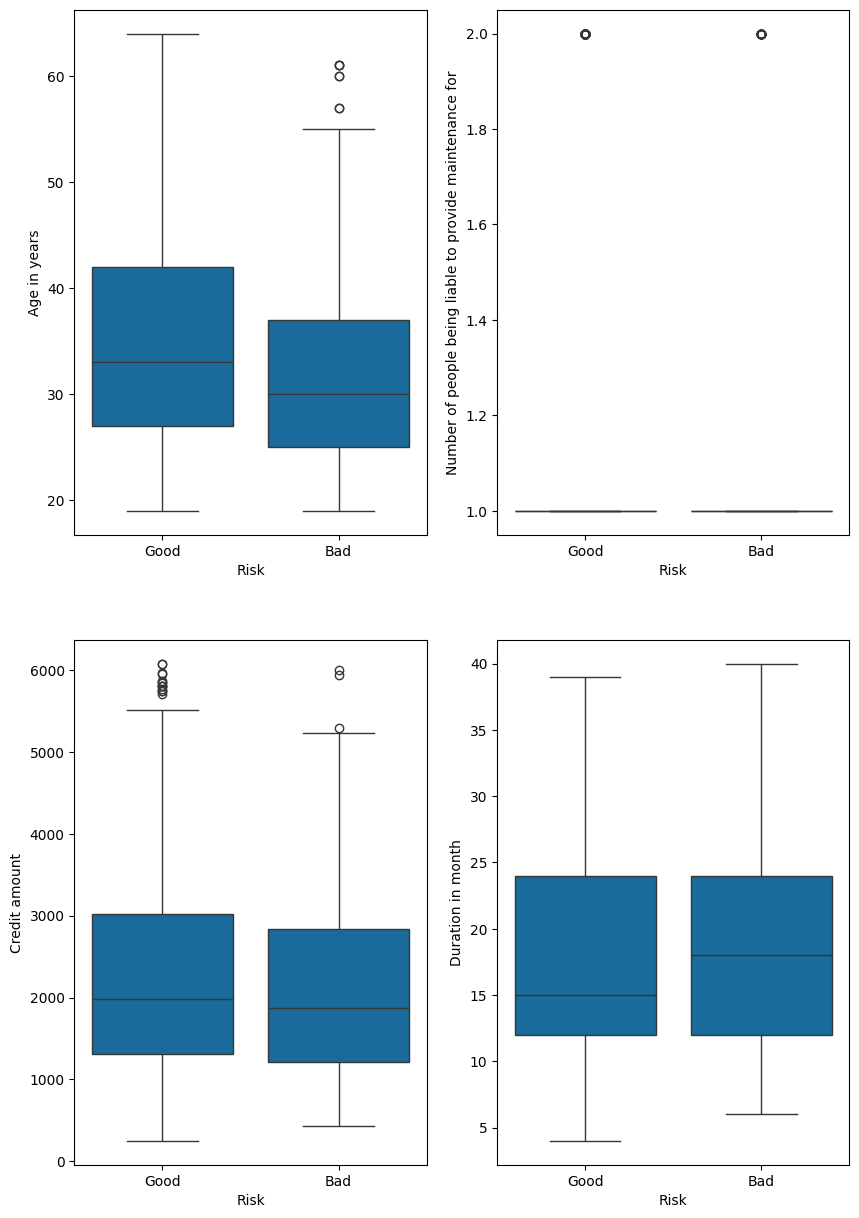

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 15))
sns.boxplot(x="Risk",y="Age in years",data=df_copy,ax=axes[0,0])
sns.boxplot(x="Risk",y="Credit amount",data=df_copy,ax=axes[1,0])
sns.boxplot(x="Risk",y="Duration in month",data=df_copy,ax=axes[1,1])
sns.boxplot(x="Risk",y="Number of people being liable to provide maintenance for",data=df_copy,ax=axes[0,1])
plt.show()

In [64]:
df_copy.isnull().value_counts()

Status of existing checking account  Duration in month  Credit history  Purpose  Credit amount  Savings account/bonds  Present employment since  Installment rate in percentage of disposable income  Personal status and sex  Other debtors / guarantors  Present residence since  Property  Age in years  Other installment plans   Housing  Number of existing credits at this bank  Job    Number of people being liable to provide maintenance for  Telephone  foreign worker  Risk 
False                                False              False           False    False          False                  False                     False                                                False                    False                       False                    False     False         False                     False    False                                    False  False                                                     False      False           False    807
Name: count, dtype: int64

In [65]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 807 entries, 2 to 997
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   Status of existing checking account                       807 non-null    object
 1   Duration in month                                         807 non-null    int64 
 2   Credit history                                            807 non-null    object
 3   Purpose                                                   807 non-null    object
 4   Credit amount                                             807 non-null    int64 
 5   Savings account/bonds                                     807 non-null    object
 6   Present employment since                                  807 non-null    object
 7   Installment rate in percentage of disposable income       807 non-null    int64 
 8   Personal status and sex            

In [66]:
df_copy['Present employment since'] = df_copy['Present employment since'].astype('category').cat.codes
df_copy['Purpose'] = df_copy['Purpose'].astype('category').cat.codes
df_copy['Credit history'] = df_copy['Purpose'].astype('category').cat.codes
df_copy['Status of existing checking account'] = df_copy['Status of existing checking account'].astype('category').cat.codes
df_copy['Savings account/bonds'] = df_copy['Savings account/bonds'].astype('category').cat.codes
df_copy['Housing'] = df_copy['Housing'].astype('category').cat.codes
df_copy['Personal status and sex'] = df_copy['Personal status and sex'].astype('category').cat.codes
df_copy['Other debtors / guarantors'] = df_copy['Other debtors / guarantors'].astype('category').cat.codes
df_copy['Property'] = df_copy['Property'].astype('category').cat.codes
df_copy['Other installment plans '] = df_copy['Other installment plans '].astype('category').cat.codes
df_copy['Job'] = df_copy['Job'].astype('category').cat.codes
df_copy['Telephone'] = df_copy['Telephone'].astype('category').cat.codes
df_copy['foreign worker'] = df_copy['foreign worker'].astype('category').cat.codes
df_copy['Risk'] = df_copy['Risk'].astype('category').cat.codes


In [67]:
df_copy['Age in years']=np.log(df_copy['Age in years']+1)
df_copy['Credit amount']=np.log(df_copy['Credit amount']+1)
df_copy['Duration in month']=np.log(df_copy['Duration in month']+1)

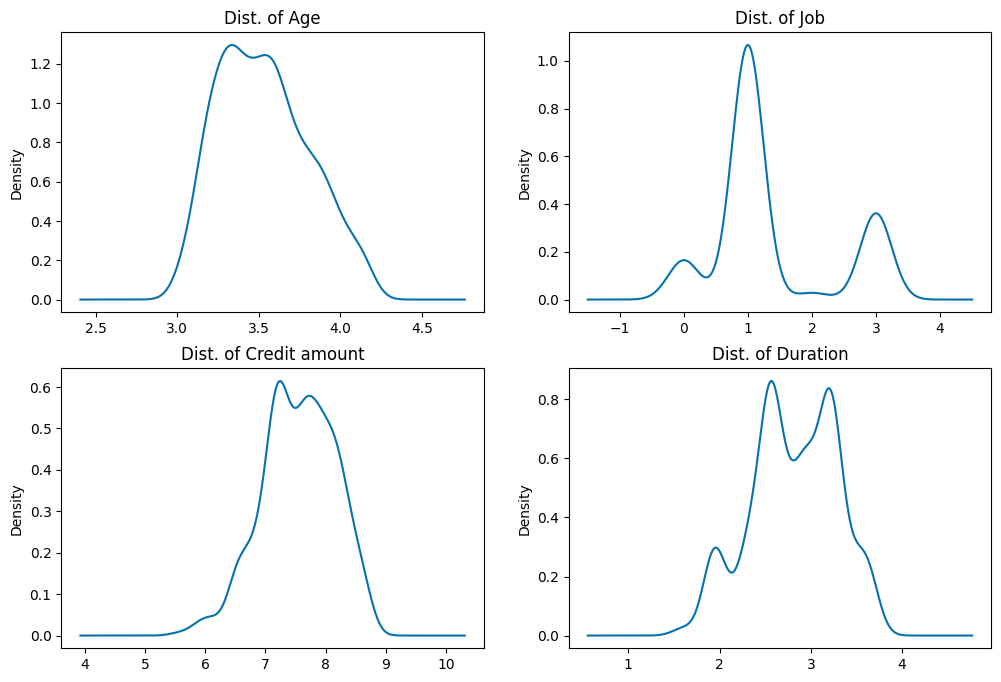

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
df_copy['Age in years'].plot(kind="density",ax=axes[0,0],title="Dist. of Age")
df_copy['Job'].plot(kind="density",ax=axes[0,1],title="Dist. of Job")
df_copy['Credit amount'].plot(kind="density",ax=axes[1,0],title="Dist. of Credit amount")
df_copy['Duration in month'].plot(kind="density",ax=axes[1,1],title="Dist. of Duration")
plt.show()

In [69]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 807 entries, 2 to 997
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Status of existing checking account                       807 non-null    int8   
 1   Duration in month                                         807 non-null    float64
 2   Credit history                                            807 non-null    int8   
 3   Purpose                                                   807 non-null    int8   
 4   Credit amount                                             807 non-null    float64
 5   Savings account/bonds                                     807 non-null    int8   
 6   Present employment since                                  807 non-null    int8   
 7   Installment rate in percentage of disposable income       807 non-null    int64  
 8   Personal status and sex  

In [70]:
df_train = df_copy
df_train.head()

,Status of existing checking account,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,...,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,foreign worker,Risk
2,3,2.564949,4,4,7.648263,2,1,2,3,2,...,2,3.912023,1,1,1,3,2,0,1,1
4,1,3.218876,1,1,8.491055,2,0,3,3,2,...,3,3.988984,1,0,2,1,2,0,1,0
6,3,3.218876,5,5,7.950150,1,3,3,3,2,...,0,3.988984,1,1,1,1,1,0,1,1
8,3,2.564949,6,6,8.026170,3,1,2,1,2,...,2,4.127134,1,1,1,3,1,0,1,1
9,0,3.433987,1,1,8.563122,2,4,4,2,2,...,1,3.367296,1,1,2,0,1,0,1,0


In [71]:
df_train.columns

Index(['Status of existing checking account', 'Duration in month',
       'Credit history', 'Purpose', 'Credit amount', 'Savings account/bonds',
       'Present employment since',
       'Installment rate in percentage of disposable income',
       'Personal status and sex', 'Other debtors / guarantors',
       'Present residence since', 'Property', 'Age in years',
       'Other installment plans ', 'Housing',
       'Number of existing credits at this bank', 'Job',
       'Number of people being liable to provide maintenance for', 'Telephone',
       'foreign worker', 'Risk'],
      dtype='object')

In [72]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 807 entries, 2 to 997
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Status of existing checking account                       807 non-null    int8   
 1   Duration in month                                         807 non-null    float64
 2   Credit history                                            807 non-null    int8   
 3   Purpose                                                   807 non-null    int8   
 4   Credit amount                                             807 non-null    float64
 5   Savings account/bonds                                     807 non-null    int8   
 6   Present employment since                                  807 non-null    int8   
 7   Installment rate in percentage of disposable income       807 non-null    int64  
 8   Personal status and sex  

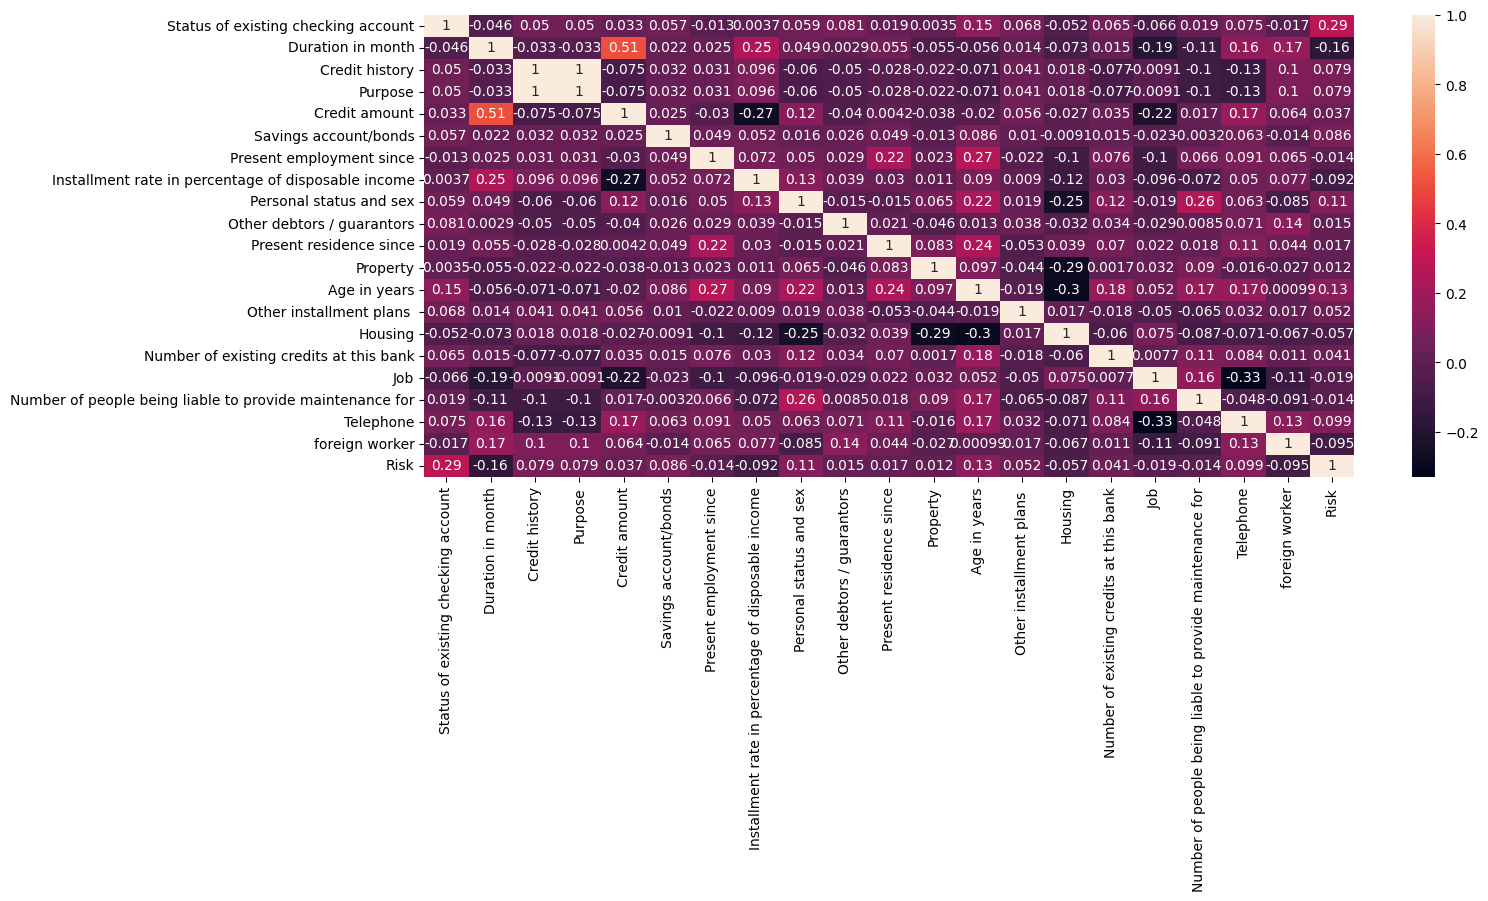

In [73]:
corr=df_train.corr() # gives us the correlation values
plt.figure(figsize=(15,6))
sns.heatmap(corr, annot = True,)  # let's visualise the correlation matrix
plt.show()

In [74]:
X = df_train.drop(['Risk'],axis=1)
y = df_train['Risk']

In [75]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

# let's call the k-best method with Chi-squared score and pass X and y as inputs

chi2 = SelectKBest(score_func = chi2, k = 'all').fit(X,y)

# create Series with variable name as index, and scores as values, and sort lowest to highest ready for plotting

chi2_sorted = pd.Series(data=chi2.scores_, index=X.columns).sort_values()

# Repeat but with other scoring functions

ftest = SelectKBest(score_func = f_classif, k = 'all').fit(X,y)
ftest_sorted = pd.Series(data=ftest.scores_, index=X.columns).sort_values()

mitest = SelectKBest(score_func = mutual_info_classif, k = 'all').fit(X,y)
mitest_sorted = pd.Series(data=mitest.scores_, index=X.columns).sort_values()

In [76]:
from sklearn.ensemble import ExtraTreesClassifier # this is a method alternative to k-best

xtrees = ExtraTreesClassifier().fit(X, y)
xtrees_sorted = pd.Series(data=xtrees.feature_importances_, index=X.columns).sort_values()

from sklearn.feature_selection import mutual_info_classif

muinfo = mutual_info_classif(X,y)
muinfo_sorted = pd.Series(data=muinfo, index=X.columns).sort_values()

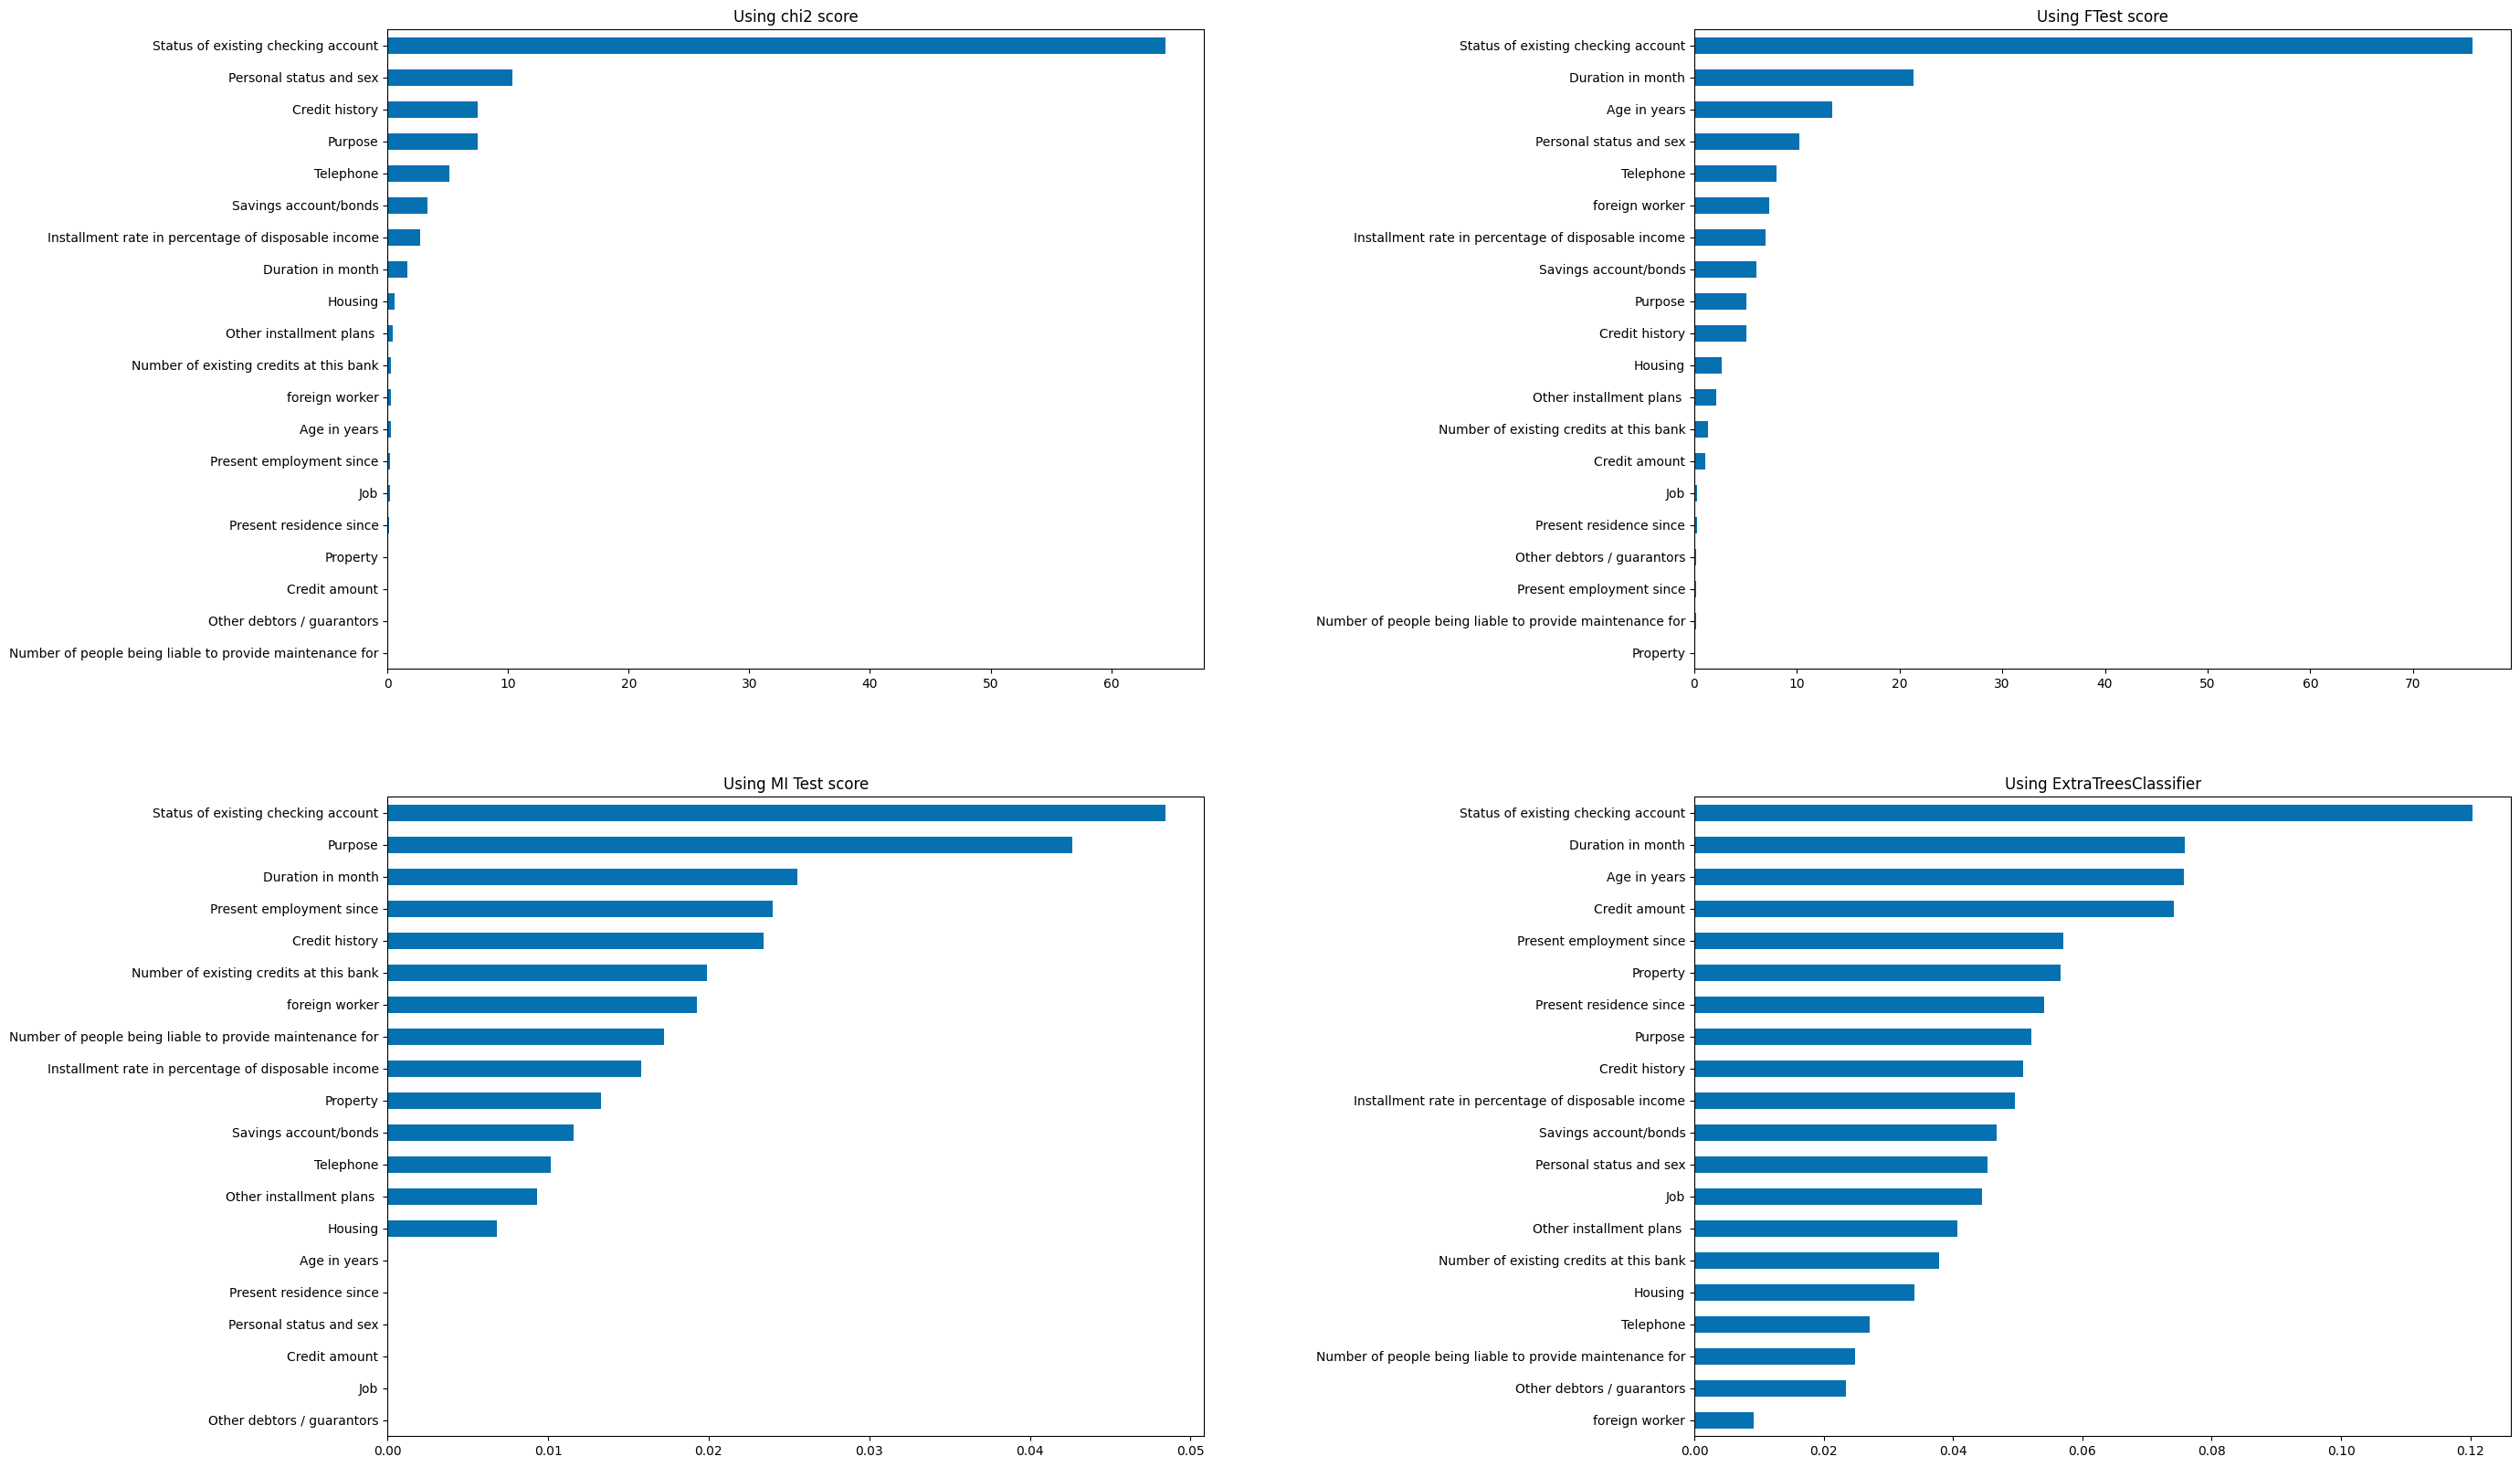

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 20))
plt.subplots_adjust(wspace=0.6)
chi2_sorted.plot(kind='barh', ax=axes[0, 0], title='Using chi2 score')
ftest_sorted.plot(kind='barh', ax=axes[0, 1], title='Using FTest score')
xtrees_sorted.plot(kind='barh', ax=axes[1, 1], title='Using ExtraTreesClassifier')
mitest_sorted.plot(kind='barh', ax=axes[1, 0], title='Using MI Test score')
plt.show()

In [78]:
X = X.drop(['Status of existing checking account'],axis=1)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(645, 19)
(162, 19)
(645,)
(162,)


In [81]:
features = list(df.columns)
features

['Status of existing checking account',
 'Duration in month',
 'Credit history',
 'Purpose',
 'Credit amount',
 'Savings account/bonds',
 'Present employment since',
 'Installment rate in percentage of disposable income',
 'Personal status and sex',
 'Other debtors / guarantors',
 'Present residence since',
 'Property',
 'Age in years',
 'Other installment plans ',
 'Housing',
 'Number of existing credits at this bank',
 'Job',
 'Number of people being liable to provide maintenance for',
 'Telephone',
 'foreign worker',
 'Risk']

In [82]:
label = features.pop(-1)
label

'Risk'

In [83]:
trainX = pd.DataFrame(X_train)
trainX[label] = y_train

In [84]:
testX = pd.DataFrame(X_test)
testX[label] = y_test

In [85]:
print(trainX.shape)
print(testX.shape)

(645, 20)
(162, 20)


In [86]:
trainX.isnull().sum()

Duration in month                                           0
Credit history                                              0
Purpose                                                     0
Credit amount                                               0
Savings account/bonds                                       0
Present employment since                                    0
Installment rate in percentage of disposable income         0
Personal status and sex                                     0
Other debtors / guarantors                                  0
Present residence since                                     0
Property                                                    0
Age in years                                                0
Other installment plans                                     0
Housing                                                     0
Number of existing credits at this bank                     0
Job                                                         0
Number o

In [87]:
testX.isnull().sum()

Duration in month                                           0
Credit history                                              0
Purpose                                                     0
Credit amount                                               0
Savings account/bonds                                       0
Present employment since                                    0
Installment rate in percentage of disposable income         0
Personal status and sex                                     0
Other debtors / guarantors                                  0
Present residence since                                     0
Property                                                    0
Age in years                                                0
Other installment plans                                     0
Housing                                                     0
Number of existing credits at this bank                     0
Job                                                         0
Number o

In [88]:
trainX.to_csv("train-V-1.csv",index=False)
testX.to_csv("test-V-1.csv",index=False)

In [89]:
sk_prefix = "sagemaker/credit_risk_analysis/sklearncontainer"
trainpath = sess.upload_data(path="train-V-1.csv",bucket=bucket,key_prefix=sk_prefix)
testpath = sess.upload_data(path="test-V-1.csv",bucket=bucket,key_prefix=sk_prefix)

print(trainpath)
print(testpath)

s3://crasagemakerbucket/sagemaker/credit_risk_analysis/sklearncontainer/train-V-1.csv
s3://crasagemakerbucket/sagemaker/credit_risk_analysis/sklearncontainer/test-V-1.csv


In [122]:
%%writefile script.py

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, accuracy_score, recall_score
import sklearn
import joblib
import boto3
import pathlib
from io import StringIO
import argparse
import os
import numpy as np
import pandas as pd


def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf

if __name__ =="__main__":

    print("[INFO] EXTRACTING ARGUMENTS")
    parser = argparse.ArgumentParser()

    # Hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--random_state", type=int, default=0)

    parser.add_argument("--model-dir",type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train",type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test",type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file",type=str, default="train-V-1.csv")
    parser.add_argument("--test-file",type=str, default="test-V-1.csv")

    args, _ = parser.parse_known_args()

    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("[INFO] Reading data")
    print()

    train_df = pd.read_csv(os.path.join(args.train,args.train_file))
    test_df = pd.read_csv(os.path.join(args.test,args.test_file))

    features = list(train_df.columns)
    label = features.pop(-1)

    print("Building training and testing datasets")
    print()

    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    print('Column order: ')
    print(features)
    print()

    print("Training Logistic Regression Model.....")
    print()
    model = RandomForestClassifier(n_estimators=args.n_estimators,random_state=args.random_state)
    model.fit(X_train, y_train)
    print()

    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model,model_path)
    print("Model persisted at " + model_path)
    print()

    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_rep = classification_report(y_test, y_pred_test)

    print()
    print("------ METRICS RESULTS FOR TESTING DATA ------")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ' )
    print(test_rep)

Overwriting script.py


In [123]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point = "script.py",
    role = "arn:aws:iam::124157440437:role/SageMakerRole",
    instance_count = 1,
    instance_type = "ml.m5.large",
    framework_version = FRAMEWORK_VERSION,
    base_job_name = "LR-custom-sklearn",
    hyperparameters={
        "n_estimators":100,
        "random_state":0,
    },
    use_spot_instances = True,
    max_wait = 7200,
    max_run = 3600
)



sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\naman\AppData\Local\sagemaker\sagemaker\config.yaml


In [124]:
# launch training job, with async call
sklearn_estimator.fit({"train":trainpath,"test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: LR-custom-sklearn-2023-12-07-15-43-53-364


Using provided s3_resource
2023-12-07 15:43:54 Starting - Starting the training job...
2023-12-07 15:44:11 Starting - Preparing the instances for training......
2023-12-07 15:45:12 Downloading - Downloading input data...
2023-12-07 15:45:47 Training - Downloading the training image...
2023-12-07 15:46:23 Uploading - Uploading generated training model2023-12-07 15:46:14,998 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-12-07 15:46:15,001 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-07 15:46:15,037 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-12-07 15:46:15,185 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-07 15:46:15,196 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-07 15:46:15,208 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-0

In [125]:
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(
    TrainingJobName = sklearn_estimator.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)


2023-12-07 15:46:34 Starting - Preparing the instances for training
2023-12-07 15:46:34 Downloading - Downloading input data
2023-12-07 15:46:34 Training - Training image download completed. Training in progress.
2023-12-07 15:46:34 Uploading - Uploading generated training model
2023-12-07 15:46:34 Completed - Training job completed
Model artifact persisted at s3://sagemaker-eu-west-2-124157440437/LR-custom-sklearn-2023-12-07-15-43-53-364/output/model.tar.gz


In [126]:
artifact

's3://sagemaker-eu-west-2-124157440437/LR-custom-sklearn-2023-12-07-15-43-53-364/output/model.tar.gz'

In [127]:
from sagemaker.sklearn.model import SKLearnModel
from time import gmtime, strftime

model_name = "Custome-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S",gmtime())
model = SKLearnModel(
    name = model_name,
    model_data = artifact,
    role = "arn:aws:iam::124157440437:role/SageMakerRole",
    entry_point = "script.py",
    framework_version = FRAMEWORK_VERSION,
) 

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\naman\AppData\Local\sagemaker\sagemaker\config.yaml


In [129]:
model_name

'Custome-sklearn-model-2023-12-07-16-09-55'

In [130]:
##Endpoint Deployment
endpoint_name = "Custome-sklearn-model-" + strftime("%Y-%m-%d-%H-%M-%S",gmtime())
print("EndpointName={}".format(endpoint_name))

predictor = model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.m4.xlarge",
    endpoint_name = endpoint_name, 
)

EndpointName=Custome-sklearn-model-2023-12-07-16-12-27
sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\naman\AppData\Local\sagemaker\sagemaker\config.yaml


INFO:sagemaker:Creating model with name: Custome-sklearn-model-2023-12-07-16-09-55
INFO:sagemaker:Creating endpoint-config with name Custome-sklearn-model-2023-12-07-16-12-27
INFO:sagemaker:Creating endpoint with name Custome-sklearn-model-2023-12-07-16-12-27


-----!

In [132]:
predictor

In [144]:
testX[features[1:]]


,Duration in month,Credit history,Purpose,Credit amount,Savings account/bonds,Present employment since,Installment rate in percentage of disposable income,Personal status and sex,Other debtors / guarantors,Present residence since,Property,Age in years,Other installment plans,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone
860,3.218876,2,2,8.666475,3,0,4,3,2,2,2,3.332205,1,1,2,1,1,0
376,2.944439,6,6,7.749753,2,4,2,2,2,3,2,3.555348,1,1,2,1,1,0
298,2.944439,5,5,7.830426,2,0,3,3,2,4,2,3.784190,1,1,1,1,1,1
423,3.091042,5,5,7.372746,0,1,4,3,2,3,2,3.555348,1,1,2,0,1,0
658,3.433987,0,0,8.348064,2,0,2,0,2,1,1,3.367296,1,1,2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,2.944439,1,1,8.285765,2,3,1,0,2,4,2,3.526361,0,2,3,1,1,1
834,2.772589,6,6,7.752765,2,2,2,0,2,3,2,3.258097,1,1,1,3,1,0
932,2.302585,1,1,7.110696,2,0,3,3,2,1,2,3.433987,1,1,2,1,1,0
930,3.218876,5,5,7.466228,2,2,4,3,0,1,0,3.218876,1,1,1,3,1,0


In [146]:
print(predictor.predict(testX[features[1:]].values.tolist()))

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>
". See https://eu-west-2.console.aws.amazon.com/cloudwatch/home?region=eu-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/Custome-sklearn-model-2023-12-07-16-12-27 in account 124157440437 for more information.

In [149]:
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '62e1f6a8-a3f4-4ac8-a124-a74c59b8427e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '62e1f6a8-a3f4-4ac8-a124-a74c59b8427e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 07 Dec 2023 16:28:36 GMT'},
  'RetryAttempts': 0}}